In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import os
import torchvision
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(0)

In [3]:
class opt:
    layer_num=784
    h_dim1=512
    h_dim2=256
    h_dim3=128
    h_dim4=64
    h_dim5=0
    h_dim6=0
    one_class=0
    lr=0.001
    finetune_epoch=10

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
class AE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3,h_dim4,h_dim5,h_dim6):
        super(AE, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2,  h_dim3,h_dim4,h_dim5, h_dim6)
        # decoder part
        self.decoder = Generator(x_dim, h_dim1, h_dim2, h_dim3,h_dim4,h_dim5,h_dim6)
    
    def recon_error(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return torch.norm((x_recon - x), dim=1)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def representation(self,x):
        z = self.encoder(x)
        return z
        
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2,h_dim3,h_dim4,h_dim5,h_dim6):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        if h_dim4>0:
            self.fc4 = nn.Linear(h_dim3,h_dim4)
        if h_dim5 >0:
            self.fc5 = nn.Linear(h_dim4,h_dim5)
        if h_dim6 >0:
            self.fc6 = nn.Linear(h_dim5,h_dim6)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        if opt.h_dim6 >0:
            h = F.relu(self.fc3(h))
            h = F.relu(self.fc4(h))
            h = F.relu(self.fc5(h))
            h = self.fc6(h)
        elif opt.h_dim5 >0:
            h = F.relu(self.fc3(h))
            h = F.relu(self.fc4(h))
            h = self.fc5(h)
        elif opt.h_dim4 >0:
            h = F.relu(self.fc3(h))
            h = self.fc4(h)
        else:
            h = self.fc3(h)
        return h
    
    
class Generator(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2,h_dim3,h_dim4,h_dim5, h_dim6):
        super(Generator, self).__init__()
        if h_dim6 >0:
            self.fc6 = nn.Linear(h_dim6,h_dim5)
        if h_dim5 >0:
            self.fc5 = nn.Linear(h_dim5,h_dim4)
        if h_dim4 >0:
            self.fc4 = nn.Linear(h_dim4,h_dim3)
        self.fc3 = nn.Linear(h_dim3, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc1 = nn.Linear(h_dim1, x_dim)
    
    def forward(self, z):
        if opt.h_dim6 >0:
            h = F.relu(self.fc6(z))
            h = F.relu(self.fc5(h))
            h = F.relu(self.fc4(h))
            h = F.relu(self.fc3(h))
        elif opt.h_dim5 >0:
            h = F.relu(self.fc5(z))
            h = F.relu(self.fc4(h))
            h = F.relu(self.fc3(h))
        elif opt.h_dim4>0:
            h = F.relu(self.fc4(z))
            h = F.relu(self.fc3(h))
        else:
            h = F.relu(self.fc3(z))

        h = F.relu(self.fc2(h))
        return self.fc1(h)

model = AE(opt.layer_num, opt.h_dim1, opt.h_dim2, opt.h_dim3,opt.h_dim4,opt.h_dim5,opt.h_dim6)

In [6]:
model_name = 'MNIST_{}_{}_{}_{}_{}_{}'.format(opt.h_dim1, opt.h_dim2, opt.h_dim3, opt.h_dim4, opt.h_dim5, opt.h_dim6)
model_path = model_name+'_holdout_{}_epoch_100.pth'.format(opt.one_class)

In [7]:
model.load_state_dict(torch.load(os.path.join('trained_model',model_path),map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
model

AE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Generator(
    (fc4): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [9]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5,), (1.0,))
])

ind_dataset = torchvision.datasets.MNIST('./MNIST_DATASET', transform=mnist_transform, train=False, download=True)
train_dataset = torchvision.datasets.MNIST('./MNIST_DATASET', transform=mnist_transform, train=True, download=True)

idx = train_dataset.targets!=opt.one_class
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                         batch_size=64,
                         shuffle=True)

idx = ind_dataset.targets!=opt.one_class
ind_dataset.targets = ind_dataset.targets[idx]
ind_dataset.data = ind_dataset.data[idx]

ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset, 
                         batch_size=64,
                         shuffle=False)

In [10]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5,), (1.0,))
])

ood_dataset = torchvision.datasets.MNIST('./MNIST_DATASET', transform=mnist_transform, train=False, download=True)

idx = ood_dataset.targets==opt.one_class
ood_dataset.targets = ood_dataset.targets[idx]
ood_dataset.data = ood_dataset.data[idx]

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset, 
                         batch_size=64,
                         shuffle=False)

In [11]:
model.eval()
model.cuda()
avg_loss = 0
step = 0
for i, (data,label) in enumerate(ind_loader):
    step += 1
    data = data.reshape(-1,784).cuda()
    with torch.no_grad():
        recon_error = model.recon_error(data)
        representation = model.representation(data)
    if i==0:
        ind_recon = recon_error
        ind_latents = representation
    else:
        ind_recon=torch.cat((ind_recon,recon_error),0)
        ind_latents=torch.cat((ind_latents,representation),0)

In [12]:
model.eval()
avg_loss = 0
step = 0
for i, (data,label) in enumerate(ood_loader):
    step += 1
    data = data.reshape(-1,784).cuda()
    with torch.no_grad():
        recon_error = model.recon_error(data)
        representation = model.representation(data)
    if i==0:
        ood_recon = recon_error
        ood_latents = representation

    else:
        ood_recon=torch.cat((ood_recon,recon_error),0)
        ood_latents=torch.cat((ood_latents,representation),0)

In [13]:
ind_latents.shape, ood_latents.shape

(torch.Size([9020, 64]), torch.Size([980, 64]))

In [14]:
# from sklearn.manifold import TSNE

# TSNE_ind_latents = TSNE(n_components=2).fit_transform(ind_latents.cpu().numpy())
# TSNE_ood_latents = TSNE(n_components=2).fit_transform(ood_latents.cpu().numpy())

In [15]:
# plt.scatter(TSNE_ind_latents[:,0],TSNE_ind_latents[:,1])
# plt.scatter(TSNE_ood_latents[:,0],TSNE_ood_latents[:,1])

In [16]:
# ind_recon.shape, ood_recon.shape

<AxesSubplot:ylabel='Density'>

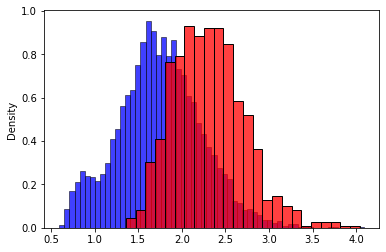

In [17]:
sns.histplot(ind_recon.detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon.detach().cpu().numpy(),color='red',stat='density')

In [18]:
torch.mean(ind_recon), torch.mean(ood_recon)

(tensor(1.7438, device='cuda:0'), tensor(2.3071, device='cuda:0'))

In [19]:
ind_size=ind_recon.detach().cpu().numpy().shape[0]
ood_size=ood_recon.detach().cpu().numpy().shape[0]

metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.detach().cpu().numpy(),ood_recon.detach().cpu().numpy())))

0.8180756482193764

In [20]:
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.encoder.fc1.weight == 0)
            + torch.sum(model.encoder.fc2.weight == 0)
            + torch.sum(model.encoder.fc3.weight == 0)
            + torch.sum(model.encoder.fc4.weight == 0)
            
            + torch.sum(model.decoder.fc1.weight == 0)
            + torch.sum(model.decoder.fc2.weight == 0)
            + torch.sum(model.decoder.fc3.weight == 0)
            + torch.sum(model.decoder.fc4.weight == 0)

        )
        / count_parameters(model)
        )
    )

Global sparsity: 0.00%


### After Pruning

In [21]:
ind_recon_pruned = []
ood_recon_pruned = []
ind_recon_mean_pruned = []
ood_recon_mean_pruned = []

auroc_pruned=[]
ind_recon_pruned_finetune = []
ood_recon_pruned_finetune = []
ind_recon_mean_pruned_finetune = []
ood_recon_mean_pruned_finetune = []

auroc_pruned_finetune=[]

pruned_models = dict()
pruned_finetuned_models=dict()

xaxis_range = [0,0.1,0.3,0.5,0.7,0.8,0.9,0.91,0.92,0.925,0.93,0.935,0.94,0.945,0.95,0.955,0.96,0.965,0.97,0.98,0.99]


for i, percent in enumerate(xaxis_range):
    print(percent)
    pruned_model = AE(opt.layer_num, opt.h_dim1, opt.h_dim2, opt.h_dim3,opt.h_dim4,opt.h_dim5,opt.h_dim6)
    model_name = 'MNIST_{}_{}_{}_{}_{}_{}'.format(opt.h_dim1, opt.h_dim2, opt.h_dim3, opt.h_dim4, opt.h_dim5, opt.h_dim6)
    model_path = model_name+'_holdout_{}_epoch_100.pth'.format(opt.one_class)
    pruned_model.load_state_dict(torch.load(os.path.join('trained_model',model_path),map_location=torch.device('cpu')))
    
    parameters_to_prune = (
        (pruned_model.encoder.fc1,'weight'),
        (pruned_model.encoder.fc2,'weight'),
        (pruned_model.encoder.fc3,'weight'),
        (pruned_model.encoder.fc4,'weight'),

        (pruned_model.decoder.fc1,'weight'),
        (pruned_model.decoder.fc2,'weight'),
        (pruned_model.decoder.fc3,'weight'),
        (pruned_model.decoder.fc4,'weight'),
    )
    
    prune.global_unstructured(
    parameters_to_prune,
    pruning_method = prune.L1Unstructured,
    amount=percent)
    
    pruned_models['{:.3f}'.format(percent)]=pruned_model
    
    pruned_model.eval()
    pruned_model.cuda()
    avg_loss = 0
    step = 0
    
    for i, (data,label) in enumerate(ind_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ind_recon = recon_error
        else:
            ind_recon=torch.cat((ind_recon,recon_error),0)
            
    pruned_model.eval()
    avg_loss = 0
    step = 0
    for i, (data,label) in enumerate(ood_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ood_recon = recon_error
        else:
            ood_recon=torch.cat((ood_recon,recon_error),0)
    
    ind_size=ind_recon.cpu().numpy().shape[0]
    ood_size=ood_recon.cpu().numpy().shape[0]

    auroc = metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.cpu().numpy(),ood_recon.cpu().numpy())))
    print('before finetuning : auroc = {}'.format(auroc))

    ind_recon_pruned.append(ind_recon)
    ood_recon_pruned.append(ood_recon)
    ind_recon_mean_pruned.append(torch.mean(ind_recon))
    ood_recon_mean_pruned.append(torch.mean(ood_recon))

    auroc_pruned.append(auroc)
    
    print(
        "Global sparsity before finetuned: {:.2f}%".format(
            100. * float(
                torch.sum(pruned_model.encoder.fc1.weight == 0)
                + torch.sum(pruned_model.encoder.fc2.weight == 0)
                + torch.sum(pruned_model.encoder.fc3.weight == 0)
                + torch.sum(pruned_model.encoder.fc4.weight == 0)

                + torch.sum(pruned_model.decoder.fc1.weight == 0)
                + torch.sum(pruned_model.decoder.fc2.weight == 0)
                + torch.sum(pruned_model.decoder.fc3.weight == 0)
                + torch.sum(pruned_model.decoder.fc4.weight == 0)

            )
            / count_parameters(pruned_model)
            )
        )
    optimizer = torch.optim.Adam(pruned_model.parameters(), opt.lr)
    schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.finetune_epoch, eta_min=0, last_epoch=-1)

    pruned_model.train()
    for epoch in range(1, opt.finetune_epoch+ 1):
        avg_loss = 0
        step = 0
        for (data,label) in tqdm(train_loader):
            step += 1
            data = data.reshape(-1,784).cuda()
            optimizer.zero_grad()
            recon_error = pruned_model.recon_error(data)
            loss = torch.mean(recon_error)
            loss.backward()
            optimizer.step()
            avg_loss += loss
#             if i % 100 == 0:    
        print('Epoch [{}/{}] Batch [{}/{}]=> Loss: {:.5f}'.format(epoch, opt.finetune_epoch, i,len(train_loader), avg_loss / step))

    model_state = pruned_model.state_dict()
    #print(model_state)
    ckpt_name = '{}_holdout_{}_pruned_finetune'.format(model_name,opt.one_class,epoch)
    ckpt_path = os.path.join('trained_model',ckpt_name + ".pth")
    
    pruned_model.eval()
    pruned_model.cuda()
    avg_loss = 0
    step = 0
    
    for i, (data,label) in enumerate(ind_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ind_recon = recon_error
        else:
            ind_recon=torch.cat((ind_recon,recon_error),0)
            
    pruned_model.eval()
    avg_loss = 0
    step = 0
    for i, (data,label) in enumerate(ood_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ood_recon = recon_error
        else:
            ood_recon=torch.cat((ood_recon,recon_error),0)
    
    pruned_finetuned_models['{:.3f}'.format(percent)]=pruned_model
    ind_size=ind_recon.cpu().numpy().shape[0]
    ood_size=ood_recon.cpu().numpy().shape[0]

    auroc = metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.cpu().numpy(),ood_recon.cpu().numpy())))
    print('after finetuning : auroc = {}'.format(auroc))
    ind_recon_pruned_finetune.append(ind_recon)
    ood_recon_pruned_finetune.append(ood_recon)
    ind_recon_mean_pruned_finetune.append(torch.mean(ind_recon))
    ood_recon_mean_pruned_finetune.append(torch.mean(ood_recon))

    auroc_pruned_finetune.append(auroc)
    
    print(
        "Global sparsity after finetuned: {:.2f}%".format(
            100. * float(
                torch.sum(pruned_model.encoder.fc1.weight == 0)
                + torch.sum(pruned_model.encoder.fc2.weight == 0)
                + torch.sum(pruned_model.encoder.fc3.weight == 0)
                + torch.sum(pruned_model.encoder.fc4.weight == 0)

                + torch.sum(pruned_model.decoder.fc1.weight == 0)
                + torch.sum(pruned_model.decoder.fc2.weight == 0)
                + torch.sum(pruned_model.decoder.fc3.weight == 0)
                + torch.sum(pruned_model.decoder.fc4.weight == 0)

            )
            / count_parameters(pruned_model)
            )
        )

0


  1%|          | 7/845 [00:00<00:12, 67.14it/s]

before finetuning : auroc = 0.8180756482193764
Global sparsity before finetuned: 0.00%


  1%|          | 8/845 [00:00<00:11, 71.59it/s]

Epoch [1/10] Batch [15/845]=> Loss: 1.78827


  1%|          | 8/845 [00:00<00:11, 73.29it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.74929


  1%|          | 8/845 [00:00<00:11, 72.94it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.74390


  1%|          | 8/845 [00:00<00:11, 71.58it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.74451


  1%|          | 8/845 [00:00<00:11, 73.67it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.74075


  1%|          | 8/845 [00:00<00:11, 71.92it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.74243


  1%|          | 8/845 [00:00<00:11, 73.96it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.73678


  1%|          | 8/845 [00:00<00:11, 73.33it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.73667


  1%|          | 8/845 [00:00<00:11, 70.88it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.73341


100%|██████████| 845/845 [00:11<00:00, 74.93it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.73408
after finetuning : auroc = 0.8182939838906738
Global sparsity after finetuned: 0.00%
0.1


  1%|          | 8/845 [00:00<00:11, 71.48it/s]

before finetuning : auroc = 0.8171881080591882
Global sparsity before finetuned: 9.98%


  1%|          | 8/845 [00:00<00:11, 71.29it/s]

Epoch [1/10] Batch [15/845]=> Loss: 1.77555


  1%|          | 8/845 [00:00<00:11, 71.02it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.73999


  1%|          | 8/845 [00:00<00:11, 73.11it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.73919


  1%|          | 8/845 [00:00<00:11, 73.26it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.73837


  1%|          | 8/845 [00:00<00:11, 73.32it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.73601


  1%|          | 8/845 [00:00<00:11, 73.19it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.73381


  1%|          | 8/845 [00:00<00:11, 73.07it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.73116


  1%|          | 8/845 [00:00<00:11, 73.41it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.73141


  1%|          | 8/845 [00:00<00:11, 72.27it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.72611


100%|██████████| 845/845 [00:11<00:00, 75.82it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.72592
after finetuning : auroc = 0.8357206208425721
Global sparsity after finetuned: 9.98%
0.3


  1%|          | 8/845 [00:00<00:11, 73.37it/s]

before finetuning : auroc = 0.8378034073939997
Global sparsity before finetuned: 29.93%


  1%|          | 8/845 [00:00<00:11, 72.19it/s]

Epoch [1/10] Batch [15/845]=> Loss: 1.75542


  1%|          | 8/845 [00:00<00:11, 72.60it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.71904


  1%|          | 8/845 [00:00<00:11, 73.51it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.71731


  1%|          | 8/845 [00:00<00:11, 71.96it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.71535


  1%|          | 8/845 [00:00<00:11, 71.81it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.71382


  1%|          | 8/845 [00:00<00:11, 72.50it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.71040


  1%|          | 8/845 [00:00<00:11, 73.22it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.70979


  1%|          | 8/845 [00:00<00:11, 73.87it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.70771


  1%|          | 8/845 [00:00<00:11, 72.82it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.70899


100%|██████████| 845/845 [00:11<00:00, 75.95it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.70497
after finetuning : auroc = 0.8191525069007648
Global sparsity after finetuned: 29.93%
0.5


  1%|          | 8/845 [00:00<00:11, 74.66it/s]

before finetuning : auroc = 0.8745360649803159
Global sparsity before finetuned: 49.89%


  1%|          | 8/845 [00:00<00:11, 74.85it/s]

Epoch [1/10] Batch [15/845]=> Loss: 1.76303


  1%|          | 8/845 [00:00<00:11, 71.24it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.71080


  1%|          | 8/845 [00:00<00:11, 71.89it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.70456


  1%|          | 8/845 [00:00<00:11, 71.56it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.70162


  1%|          | 8/845 [00:00<00:11, 71.91it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.69757


  1%|          | 8/845 [00:00<00:11, 72.76it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.69805


  1%|          | 8/845 [00:00<00:11, 72.08it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.69369


  1%|          | 7/845 [00:00<00:13, 62.37it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.69519


  1%|          | 8/845 [00:00<00:11, 72.42it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.69225


100%|██████████| 845/845 [00:11<00:00, 76.13it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.69009
after finetuning : auroc = 0.8198912846735146
Global sparsity after finetuned: 49.89%
0.7


  1%|          | 8/845 [00:00<00:11, 71.70it/s]

before finetuning : auroc = 0.8903213946332413
Global sparsity before finetuned: 69.84%


  1%|          | 8/845 [00:00<00:11, 72.94it/s]

Epoch [1/10] Batch [15/845]=> Loss: 1.87919


  1%|          | 8/845 [00:00<00:11, 71.47it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.73011


  1%|          | 8/845 [00:00<00:11, 72.75it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.71738


  1%|          | 8/845 [00:00<00:11, 72.78it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.71062


  1%|          | 8/845 [00:00<00:11, 72.93it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.70526


  1%|          | 7/845 [00:00<00:13, 62.54it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.70206


  1%|          | 7/845 [00:00<00:13, 62.98it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.69707


  1%|          | 8/845 [00:00<00:11, 72.57it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.69477


  1%|          | 7/845 [00:00<00:13, 62.99it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.69289


100%|██████████| 845/845 [00:11<00:00, 76.34it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.69145
after finetuning : auroc = 0.8195235078510339
Global sparsity after finetuned: 69.84%
0.8


  1%|          | 8/845 [00:00<00:11, 71.77it/s]

before finetuning : auroc = 0.8593181818181818
Global sparsity before finetuned: 79.82%


  1%|          | 8/845 [00:00<00:11, 72.52it/s]

Epoch [1/10] Batch [15/845]=> Loss: 2.11162


  1%|          | 8/845 [00:00<00:11, 72.96it/s]

Epoch [2/10] Batch [15/845]=> Loss: 1.79516


  1%|          | 8/845 [00:00<00:11, 71.09it/s]

Epoch [3/10] Batch [15/845]=> Loss: 1.76201


  1%|          | 8/845 [00:00<00:11, 72.59it/s]

Epoch [4/10] Batch [15/845]=> Loss: 1.74766


  1%|          | 8/845 [00:00<00:11, 72.86it/s]

Epoch [5/10] Batch [15/845]=> Loss: 1.73796


  1%|          | 8/845 [00:00<00:11, 72.80it/s]

Epoch [6/10] Batch [15/845]=> Loss: 1.73098


  1%|          | 8/845 [00:00<00:11, 72.84it/s]

Epoch [7/10] Batch [15/845]=> Loss: 1.72617


  1%|          | 8/845 [00:00<00:11, 72.88it/s]

Epoch [8/10] Batch [15/845]=> Loss: 1.72204


  1%|          | 8/845 [00:00<00:11, 73.07it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.71903


100%|██████████| 845/845 [00:10<00:00, 77.84it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.71560
after finetuning : auroc = 0.8147699556541022
Global sparsity after finetuned: 79.82%
0.9


  1%|          | 8/845 [00:00<00:11, 72.77it/s]

before finetuning : auroc = 0.852575173084755
Global sparsity before finetuned: 89.79%


  1%|          | 8/845 [00:00<00:11, 72.24it/s]

Epoch [1/10] Batch [15/845]=> Loss: 3.21743


  1%|          | 8/845 [00:00<00:11, 72.24it/s]

Epoch [2/10] Batch [15/845]=> Loss: 2.35730


  1%|          | 8/845 [00:00<00:11, 72.60it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.20846


  1%|          | 8/845 [00:00<00:11, 72.83it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.13130


  1%|          | 8/845 [00:00<00:11, 72.91it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.08284


  1%|          | 8/845 [00:00<00:11, 72.18it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.04801


  1%|          | 8/845 [00:00<00:11, 72.79it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.02164


  1%|          | 8/845 [00:00<00:10, 76.20it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.00145


  1%|          | 8/845 [00:00<00:11, 74.92it/s]

Epoch [9/10] Batch [15/845]=> Loss: 1.98494


100%|██████████| 845/845 [00:11<00:00, 76.75it/s]


Epoch [10/10] Batch [15/845]=> Loss: 1.96869
after finetuning : auroc = 0.813584890719037
Global sparsity after finetuned: 89.79%
0.91


  1%|          | 8/845 [00:00<00:11, 75.62it/s]

before finetuning : auroc = 0.8623609099959275
Global sparsity before finetuned: 90.79%


  1%|          | 8/845 [00:00<00:11, 75.10it/s]

Epoch [1/10] Batch [15/845]=> Loss: 3.44277


  1%|          | 8/845 [00:00<00:11, 76.02it/s]

Epoch [2/10] Batch [15/845]=> Loss: 2.49413


  1%|          | 8/845 [00:00<00:11, 75.97it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.32859


  1%|          | 8/845 [00:00<00:11, 74.86it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.24250


  1%|          | 8/845 [00:00<00:11, 74.74it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.18716


  1%|          | 8/845 [00:00<00:11, 75.87it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.14746


  1%|          | 8/845 [00:00<00:11, 75.92it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.11791


  1%|          | 8/845 [00:00<00:11, 75.37it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.09235


  1%|          | 8/845 [00:00<00:11, 74.97it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.07200


100%|██████████| 845/845 [00:11<00:00, 76.53it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.05322
after finetuning : auroc = 0.8170383275261324
Global sparsity after finetuned: 90.79%
0.92


  1%|          | 8/845 [00:00<00:11, 75.35it/s]

before finetuning : auroc = 0.8562274876691253
Global sparsity before finetuned: 91.79%


  1%|          | 8/845 [00:00<00:11, 75.20it/s]

Epoch [1/10] Batch [15/845]=> Loss: 3.75338


  1%|          | 8/845 [00:00<00:11, 75.03it/s]

Epoch [2/10] Batch [15/845]=> Loss: 2.68938


  1%|          | 8/845 [00:00<00:10, 76.29it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.48975


  1%|          | 8/845 [00:00<00:11, 72.39it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.38608


  1%|          | 8/845 [00:00<00:11, 72.54it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.31895


  1%|          | 8/845 [00:00<00:11, 72.35it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.27308


  1%|          | 8/845 [00:00<00:11, 72.73it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.23657


  1%|          | 8/845 [00:00<00:11, 72.82it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.20674


  1%|          | 8/845 [00:00<00:11, 72.50it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.18253


100%|██████████| 845/845 [00:11<00:00, 76.28it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.16160
after finetuning : auroc = 0.8271123693379793
Global sparsity after finetuned: 91.79%
0.925


  1%|          | 7/845 [00:00<00:11, 69.91it/s]

before finetuning : auroc = 0.8518352640390968
Global sparsity before finetuned: 92.29%


  1%|          | 8/845 [00:00<00:11, 71.10it/s]

Epoch [1/10] Batch [15/845]=> Loss: 3.88710


  1%|          | 8/845 [00:00<00:11, 71.28it/s]

Epoch [2/10] Batch [15/845]=> Loss: 2.79369


  1%|          | 7/845 [00:00<00:12, 69.18it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.57018


  1%|          | 7/845 [00:00<00:12, 68.90it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.45798


  1%|          | 7/845 [00:00<00:12, 69.77it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.38761


  1%|          | 7/845 [00:00<00:12, 68.53it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.33593


  1%|          | 7/845 [00:00<00:12, 67.50it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.29662


  1%|          | 8/845 [00:00<00:11, 71.17it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.26458


  1%|          | 8/845 [00:00<00:11, 72.66it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.23926


100%|██████████| 845/845 [00:11<00:00, 76.02it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.21667
after finetuning : auroc = 0.8213791348024798
Global sparsity after finetuned: 92.29%
0.93


  1%|          | 8/845 [00:00<00:11, 73.95it/s]

before finetuning : auroc = 0.8434228924385719
Global sparsity before finetuned: 92.79%


  1%|          | 8/845 [00:00<00:11, 72.78it/s]

Epoch [1/10] Batch [15/845]=> Loss: 4.07766


  1%|          | 8/845 [00:00<00:11, 71.15it/s]

Epoch [2/10] Batch [15/845]=> Loss: 2.92548


  1%|          | 8/845 [00:00<00:11, 71.26it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.68735


  1%|          | 8/845 [00:00<00:11, 71.22it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.56502


  1%|          | 7/845 [00:00<00:12, 69.75it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.48464


  1%|          | 7/845 [00:00<00:12, 69.80it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.42614


  1%|          | 7/845 [00:00<00:12, 69.67it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.38084


  1%|          | 7/845 [00:00<00:12, 69.78it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.34524


  1%|          | 7/845 [00:00<00:12, 69.70it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.31417


100%|██████████| 845/845 [00:11<00:00, 76.14it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.28798
after finetuning : auroc = 0.8198006697135617
Global sparsity after finetuned: 92.79%
0.935


  1%|          | 7/845 [00:00<00:12, 69.58it/s]

before finetuning : auroc = 0.8416784130503643
Global sparsity before finetuned: 93.29%


  1%|          | 8/845 [00:00<00:11, 73.67it/s]

Epoch [1/10] Batch [15/845]=> Loss: 4.26702


  1%|          | 8/845 [00:00<00:11, 73.74it/s]

Epoch [2/10] Batch [15/845]=> Loss: 3.09752


  1%|          | 8/845 [00:00<00:11, 74.32it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.84557


  1%|          | 8/845 [00:00<00:11, 75.16it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.70898


  1%|          | 8/845 [00:00<00:11, 74.71it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.61676


  1%|          | 8/845 [00:00<00:11, 71.81it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.55304


  1%|          | 8/845 [00:00<00:11, 75.30it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.50362


  1%|          | 8/845 [00:00<00:11, 75.16it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.46510


  1%|          | 8/845 [00:00<00:11, 75.89it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.43388


100%|██████████| 845/845 [00:11<00:00, 76.18it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.40523
after finetuning : auroc = 0.8125158378207159
Global sparsity after finetuned: 93.29%
0.94


  1%|          | 8/845 [00:00<00:10, 76.19it/s]

before finetuning : auroc = 0.840643241775646
Global sparsity before finetuned: 93.78%


  1%|          | 8/845 [00:00<00:11, 73.22it/s]

Epoch [1/10] Batch [15/845]=> Loss: 4.46890


  1%|          | 8/845 [00:00<00:11, 75.26it/s]

Epoch [2/10] Batch [15/845]=> Loss: 3.16317


  1%|          | 8/845 [00:00<00:11, 73.64it/s]

Epoch [3/10] Batch [15/845]=> Loss: 2.90108


  1%|          | 8/845 [00:00<00:11, 74.06it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.76599


  1%|          | 8/845 [00:00<00:11, 74.06it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.67909


  1%|          | 8/845 [00:00<00:11, 70.73it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.61648


  1%|          | 8/845 [00:00<00:11, 74.03it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.56492


  1%|          | 8/845 [00:00<00:11, 74.10it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.52410


  1%|          | 8/845 [00:00<00:11, 73.56it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.49063


100%|██████████| 845/845 [00:11<00:00, 76.53it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.46383
after finetuning : auroc = 0.8208823928684557
Global sparsity after finetuned: 93.78%
0.945


  1%|          | 8/845 [00:00<00:11, 73.95it/s]

before finetuning : auroc = 0.8432950020362913
Global sparsity before finetuned: 94.28%


  1%|          | 7/845 [00:00<00:12, 68.52it/s]

Epoch [1/10] Batch [15/845]=> Loss: 4.80815


  1%|          | 8/845 [00:00<00:11, 74.86it/s]

Epoch [2/10] Batch [15/845]=> Loss: 3.40458


  1%|          | 7/845 [00:00<00:13, 63.47it/s]

Epoch [3/10] Batch [15/845]=> Loss: 3.11842


  1%|          | 8/845 [00:00<00:11, 73.38it/s]

Epoch [4/10] Batch [15/845]=> Loss: 2.97782


  1%|          | 8/845 [00:00<00:11, 73.58it/s]

Epoch [5/10] Batch [15/845]=> Loss: 2.88991


  1%|          | 8/845 [00:00<00:11, 74.01it/s]

Epoch [6/10] Batch [15/845]=> Loss: 2.82667


  1%|          | 8/845 [00:00<00:11, 73.39it/s]

Epoch [7/10] Batch [15/845]=> Loss: 2.77770


  1%|          | 8/845 [00:00<00:11, 74.16it/s]

Epoch [8/10] Batch [15/845]=> Loss: 2.73899


  1%|          | 8/845 [00:00<00:11, 74.18it/s]

Epoch [9/10] Batch [15/845]=> Loss: 2.70517


100%|██████████| 845/845 [00:11<00:00, 76.52it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.67605
after finetuning : auroc = 0.833165245033712
Global sparsity after finetuned: 94.28%
0.95


  1%|          | 8/845 [00:00<00:11, 74.12it/s]

before finetuning : auroc = 0.8382305194805194
Global sparsity before finetuned: 94.78%


  1%|          | 8/845 [00:00<00:11, 74.72it/s]

Epoch [1/10] Batch [15/845]=> Loss: 5.17035


  1%|          | 8/845 [00:00<00:11, 74.15it/s]

Epoch [2/10] Batch [15/845]=> Loss: 3.75099


  1%|          | 8/845 [00:00<00:11, 72.58it/s]

Epoch [3/10] Batch [15/845]=> Loss: 3.45188


  1%|          | 8/845 [00:00<00:11, 72.47it/s]

Epoch [4/10] Batch [15/845]=> Loss: 3.29421


  1%|          | 7/845 [00:00<00:12, 69.14it/s]

Epoch [5/10] Batch [15/845]=> Loss: 3.19652


  1%|          | 8/845 [00:00<00:11, 70.61it/s]

Epoch [6/10] Batch [15/845]=> Loss: 3.12917


  1%|          | 8/845 [00:00<00:11, 71.31it/s]

Epoch [7/10] Batch [15/845]=> Loss: 3.07939


  1%|          | 7/845 [00:00<00:12, 68.14it/s]

Epoch [8/10] Batch [15/845]=> Loss: 3.03909


  1%|          | 7/845 [00:00<00:12, 69.04it/s]

Epoch [9/10] Batch [15/845]=> Loss: 3.00425


100%|██████████| 845/845 [00:11<00:00, 70.88it/s]


Epoch [10/10] Batch [15/845]=> Loss: 2.97629
after finetuning : auroc = 0.837993857188108
Global sparsity after finetuned: 94.78%
0.955


  1%|          | 7/845 [00:00<00:11, 69.96it/s]

before finetuning : auroc = 0.8398727883614644
Global sparsity before finetuned: 95.28%


  1%|          | 7/845 [00:00<00:12, 69.13it/s]

Epoch [1/10] Batch [15/845]=> Loss: 5.80978


  1%|          | 8/845 [00:00<00:11, 72.21it/s]

Epoch [2/10] Batch [15/845]=> Loss: 4.64399


  1%|          | 7/845 [00:00<00:12, 66.23it/s]

Epoch [3/10] Batch [15/845]=> Loss: 4.42111


  1%|          | 7/845 [00:00<00:12, 68.21it/s]

Epoch [4/10] Batch [15/845]=> Loss: 4.30038


  1%|          | 8/845 [00:00<00:11, 71.38it/s]

Epoch [5/10] Batch [15/845]=> Loss: 4.21660


  1%|          | 7/845 [00:00<00:11, 69.90it/s]

Epoch [6/10] Batch [15/845]=> Loss: 4.14608


  1%|          | 7/845 [00:00<00:12, 68.12it/s]

Epoch [7/10] Batch [15/845]=> Loss: 4.09174


  1%|          | 7/845 [00:00<00:12, 66.98it/s]

Epoch [8/10] Batch [15/845]=> Loss: 4.05100


  1%|          | 8/845 [00:00<00:11, 72.19it/s]

Epoch [9/10] Batch [15/845]=> Loss: 4.01512


100%|██████████| 845/845 [00:11<00:00, 72.92it/s]


Epoch [10/10] Batch [15/845]=> Loss: 3.98625
after finetuning : auroc = 0.930593918276845
Global sparsity after finetuned: 95.28%
0.96


  1%|          | 7/845 [00:00<00:12, 67.43it/s]

before finetuning : auroc = 0.8437999456989005
Global sparsity before finetuned: 95.78%


  1%|          | 8/845 [00:00<00:11, 70.45it/s]

Epoch [1/10] Batch [15/845]=> Loss: 6.20377


  1%|          | 8/845 [00:00<00:11, 70.81it/s]

Epoch [2/10] Batch [15/845]=> Loss: 5.20895


  1%|          | 7/845 [00:00<00:12, 65.99it/s]

Epoch [3/10] Batch [15/845]=> Loss: 4.99865


  1%|          | 8/845 [00:00<00:11, 71.42it/s]

Epoch [4/10] Batch [15/845]=> Loss: 4.88359


  1%|          | 8/845 [00:00<00:11, 70.55it/s]

Epoch [5/10] Batch [15/845]=> Loss: 4.80677


  1%|          | 7/845 [00:00<00:12, 69.73it/s]

Epoch [6/10] Batch [15/845]=> Loss: 4.75366


  1%|          | 7/845 [00:00<00:12, 69.59it/s]

Epoch [7/10] Batch [15/845]=> Loss: 4.71321


  1%|          | 7/845 [00:00<00:12, 69.44it/s]

Epoch [8/10] Batch [15/845]=> Loss: 4.68144


  1%|          | 8/845 [00:00<00:11, 70.63it/s]

Epoch [9/10] Batch [15/845]=> Loss: 4.65614


100%|██████████| 845/845 [00:11<00:00, 70.90it/s]


Epoch [10/10] Batch [15/845]=> Loss: 4.63401
after finetuning : auroc = 0.9124690031223132
Global sparsity after finetuned: 95.78%
0.965


  1%|          | 8/845 [00:00<00:11, 71.81it/s]

before finetuning : auroc = 0.8272547400334856
Global sparsity before finetuned: 96.28%


  1%|          | 8/845 [00:00<00:11, 71.14it/s]

Epoch [1/10] Batch [15/845]=> Loss: 6.71932


  1%|          | 7/845 [00:00<00:12, 66.23it/s]

Epoch [2/10] Batch [15/845]=> Loss: 6.22762


  1%|          | 8/845 [00:00<00:11, 74.97it/s]

Epoch [3/10] Batch [15/845]=> Loss: 6.09513


  1%|          | 8/845 [00:00<00:11, 72.24it/s]

Epoch [4/10] Batch [15/845]=> Loss: 6.03058


  1%|          | 7/845 [00:00<00:12, 68.78it/s]

Epoch [5/10] Batch [15/845]=> Loss: 5.99129


  1%|          | 8/845 [00:00<00:11, 71.32it/s]

Epoch [6/10] Batch [15/845]=> Loss: 5.96290


  1%|          | 7/845 [00:00<00:12, 68.77it/s]

Epoch [7/10] Batch [15/845]=> Loss: 5.93954


  1%|          | 7/845 [00:00<00:12, 68.98it/s]

Epoch [8/10] Batch [15/845]=> Loss: 5.91810


  1%|          | 7/845 [00:00<00:12, 65.82it/s]

Epoch [9/10] Batch [15/845]=> Loss: 5.89846


100%|██████████| 845/845 [00:11<00:00, 72.11it/s]


Epoch [10/10] Batch [15/845]=> Loss: 5.88088
after finetuning : auroc = 0.9255216299380064
Global sparsity after finetuned: 96.28%
0.97


  1%|          | 7/845 [00:00<00:12, 66.92it/s]

before finetuning : auroc = 0.8259675777184489
Global sparsity before finetuned: 96.78%


  1%|          | 7/845 [00:00<00:12, 66.90it/s]

Epoch [1/10] Batch [15/845]=> Loss: 6.81911


  1%|          | 7/845 [00:00<00:12, 68.86it/s]

Epoch [2/10] Batch [15/845]=> Loss: 6.32226


  1%|          | 7/845 [00:00<00:12, 69.73it/s]

Epoch [3/10] Batch [15/845]=> Loss: 6.20214


  1%|          | 7/845 [00:00<00:12, 66.91it/s]

Epoch [4/10] Batch [15/845]=> Loss: 6.11803


  1%|          | 8/845 [00:00<00:11, 71.70it/s]

Epoch [5/10] Batch [15/845]=> Loss: 6.05690


  1%|          | 7/845 [00:00<00:12, 67.19it/s]

Epoch [6/10] Batch [15/845]=> Loss: 6.01344


  1%|          | 8/845 [00:00<00:11, 71.91it/s]

Epoch [7/10] Batch [15/845]=> Loss: 5.98196


  1%|          | 7/845 [00:00<00:12, 67.54it/s]

Epoch [8/10] Batch [15/845]=> Loss: 5.95725


  1%|          | 7/845 [00:00<00:12, 66.16it/s]

Epoch [9/10] Batch [15/845]=> Loss: 5.93612


100%|██████████| 845/845 [00:11<00:00, 72.46it/s]


Epoch [10/10] Batch [15/845]=> Loss: 5.91735
after finetuning : auroc = 0.9137472283813747
Global sparsity after finetuned: 96.78%
0.98


  1%|          | 8/845 [00:00<00:11, 70.54it/s]

before finetuning : auroc = 0.807937802615503
Global sparsity before finetuned: 97.77%


  1%|          | 8/845 [00:00<00:11, 70.82it/s]

Epoch [1/10] Batch [15/845]=> Loss: 7.19750


  1%|          | 8/845 [00:00<00:11, 70.50it/s]

Epoch [2/10] Batch [15/845]=> Loss: 7.03375


  1%|          | 8/845 [00:00<00:11, 71.82it/s]

Epoch [3/10] Batch [15/845]=> Loss: 7.03408


  1%|          | 8/845 [00:00<00:11, 71.40it/s]

Epoch [4/10] Batch [15/845]=> Loss: 7.03398


  1%|          | 8/845 [00:00<00:11, 71.29it/s]

Epoch [5/10] Batch [15/845]=> Loss: 7.03385


  1%|          | 7/845 [00:00<00:12, 69.64it/s]

Epoch [6/10] Batch [15/845]=> Loss: 7.03374


  1%|          | 7/845 [00:00<00:12, 69.79it/s]

Epoch [7/10] Batch [15/845]=> Loss: 7.03361


  1%|          | 8/845 [00:00<00:11, 73.03it/s]

Epoch [8/10] Batch [15/845]=> Loss: 7.03342


  1%|          | 7/845 [00:00<00:12, 68.72it/s]

Epoch [9/10] Batch [15/845]=> Loss: 7.03346


100%|██████████| 845/845 [00:11<00:00, 72.31it/s]


Epoch [10/10] Batch [15/845]=> Loss: 7.03337
after finetuning : auroc = 0.866405945970406
Global sparsity after finetuned: 97.77%
0.99


  1%|          | 8/845 [00:00<00:11, 71.39it/s]

before finetuning : auroc = 0.7273581383773022
Global sparsity before finetuned: 98.77%


  1%|          | 7/845 [00:00<00:12, 67.72it/s]

Epoch [1/10] Batch [15/845]=> Loss: 7.25920


  1%|          | 8/845 [00:00<00:11, 71.82it/s]

Epoch [2/10] Batch [15/845]=> Loss: 7.03253


  1%|          | 8/845 [00:00<00:11, 71.54it/s]

Epoch [3/10] Batch [15/845]=> Loss: 7.03255


  1%|          | 8/845 [00:00<00:11, 71.00it/s]

Epoch [4/10] Batch [15/845]=> Loss: 7.03250


  1%|          | 8/845 [00:00<00:11, 70.71it/s]

Epoch [5/10] Batch [15/845]=> Loss: 7.03250


  1%|          | 7/845 [00:00<00:13, 62.95it/s]

Epoch [6/10] Batch [15/845]=> Loss: 7.03239


  1%|          | 7/845 [00:00<00:12, 68.69it/s]

Epoch [7/10] Batch [15/845]=> Loss: 7.03264


  1%|          | 7/845 [00:00<00:12, 68.54it/s]

Epoch [8/10] Batch [15/845]=> Loss: 7.03264


  1%|          | 8/845 [00:00<00:11, 70.75it/s]

Epoch [9/10] Batch [15/845]=> Loss: 7.03257


100%|██████████| 845/845 [00:11<00:00, 71.99it/s]


Epoch [10/10] Batch [15/845]=> Loss: 7.03255
after finetuning : auroc = 0.867048395855016
Global sparsity after finetuned: 98.77%


In [22]:
# percent_check = '0.95'

# pruned_models[percent_check].eval()
# pruned_models[percent_check].cuda()
# avg_loss = 0
# step = 0
# for i, (data,label) in enumerate(ind_loader):
#     step += 1
#     data = data.reshape(-1,784).cuda()
#     with torch.no_grad():
#         recon_error = pruned_models[percent_check].recon_error(data)
#         representation = pruned_models[percent_check].representation(data)
#     if i==0:
#         ind_recon = recon_error
#         ind_latents = representation
#     else:
#         ind_recon=torch.cat((ind_recon,recon_error),0)
#         ind_latents=torch.cat((ind_latents,representation),0)

In [23]:
# pruned_models[percent_check].eval()
# avg_loss = 0
# step = 0
# for i, (data,label) in enumerate(ood_loader):
#     step += 1
#     data = data.reshape(-1,784).cuda()
#     with torch.no_grad():
#         recon_error = pruned_models[percent_check].recon_error(data)
#         representation = pruned_models[percent_check].representation(data)
#     if i==0:
#         ood_recon = recon_error
#         ood_latents = representation
#     else:
#         ood_recon=torch.cat((ood_recon,recon_error),0)
#         ood_latents=torch.cat((ood_latents,representation),0)

In [24]:
# TSNE_ind_latents = TSNE(n_components=2).fit_transform(ind_latents.cpu().numpy())
# TSNE_ood_latents = TSNE(n_components=2).fit_transform(ood_latents.cpu().numpy())

In [25]:
# plt.scatter(TSNE_ind_latents[:,0],TSNE_ind_latents[:,1])
# plt.scatter(TSNE_ood_latents[:,0],TSNE_ood_latents[:,1])

In [26]:
# pruned_finetuned_models[percent_check].eval()
# pruned_finetuned_models[percent_check].cuda()
# avg_loss = 0
# step = 0
# for i, (data,label) in enumerate(ind_loader):
#     step += 1
#     data = data.reshape(-1,784).cuda()
#     with torch.no_grad():
#         recon_error = pruned_finetuned_models[percent_check].recon_error(data)
#         representation = pruned_finetuned_models[percent_check].representation(data)
#     if i==0:
#         ind_recon = recon_error
#         ind_latents = representation
#     else:
#         ind_recon=torch.cat((ind_recon,recon_error),0)
#         ind_latents=torch.cat((ind_latents,representation),0)
        
# pruned_finetuned_models[percent_check].eval()
# avg_loss = 0
# step = 0
# for i, (data,label) in enumerate(ood_loader):
#     step += 1
#     data = data.reshape(-1,784).cuda()
#     with torch.no_grad():
#         recon_error = pruned_finetuned_models[percent_check].recon_error(data)
#         representation = pruned_finetuned_models[percent_check].representation(data)
#     if i==0:
#         ood_recon = recon_error
#         ood_latents = representation
#     else:
#         ood_recon=torch.cat((ood_recon,recon_error),0)
#         ood_latents=torch.cat((ood_latents,representation),0)
        
# TSNE_ind_latents = TSNE(n_components=2).fit_transform(ind_latents.cpu().numpy())
# TSNE_ood_latents = TSNE(n_components=2).fit_transform(ood_latents.cpu().numpy())

# plt.scatter(TSNE_ind_latents[:,0],TSNE_ind_latents[:,1])
# plt.scatter(TSNE_ood_latents[:,0],TSNE_ood_latents[:,1])

In [27]:
# a = pruned_models[19].decoder.fc1.weight.data.cpu()
# b = pruned_models[19].encoder.fc3.weight.data
# c = pruned_models[19].encoder.fc2.weight.data
# d = pruned_models[19].encoder.fc1.weight.data

In [28]:
# plt.imshow(((np.abs(a) > 0).sum(axis=1) >0).reshape(28,28))

In [29]:
# (np.abs(a)==0).sum()/a.reshape(-1).shape[0]

In [30]:
# n_pruned=((np.abs(a)==0).sum()+(np.abs(b)==0).sum()+(np.abs(c)==0).sum()+(np.abs(d)==0).sum())

In [31]:
# n_parameters = a.reshape(-1).shape[0]+b.reshape(-1).shape[0]+c.reshape(-1).shape[0]+d.reshape(-1).shape[0]

In [32]:
# n_pruned / n_parameters

In [33]:
# plt.figure(figsize=(18,8))
# plt.imshow(np.abs(a), cmap='gray', interpolation='none');plt.colorbar()

In [34]:
# (np.abs(a) > 0).sum(axis=0).shape, ((np.abs(a) > 0).sum(axis=0) > 0).sum()

In [35]:
# (np.abs(a) > 0).sum(axis=1).shape, ((np.abs(a) > 0).sum(axis=1) > 0).sum()

In [36]:
# import matplotlib.pyplot as plt

In [37]:
ind_recon_mean_pruned=torch.stack(ind_recon_mean_pruned)
ood_recon_mean_pruned=torch.stack(ood_recon_mean_pruned)
ind_recon_mean_pruned_finetune=torch.stack(ind_recon_mean_pruned_finetune)
ood_recon_mean_pruned_finetune=torch.stack(ood_recon_mean_pruned_finetune)

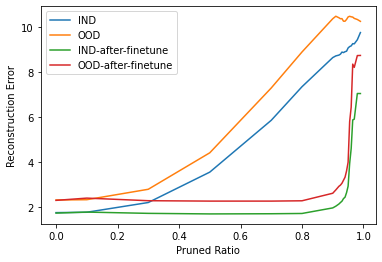

In [38]:
plt.plot(xaxis_range,ind_recon_mean_pruned.cpu().numpy())
plt.plot(xaxis_range,ood_recon_mean_pruned.cpu().numpy())
plt.plot(xaxis_range,ind_recon_mean_pruned_finetune.cpu().numpy())
plt.plot(xaxis_range,ood_recon_mean_pruned_finetune.cpu().numpy())

plt.xlabel('Pruned Ratio')
plt.ylabel('Reconstruction Error')
plt.legend(['IND','OOD','IND-after-finetune','OOD-after-finetune'])

Text(0.5, 1.0, 'max AUROC 0.931 at pruning ratio 0.95')

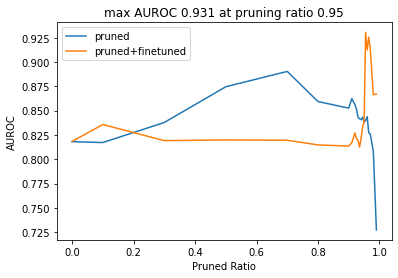

In [39]:
plt.plot(xaxis_range,auroc_pruned)
plt.plot(xaxis_range,auroc_pruned_finetune)
plt.xlabel('Pruned Ratio')
plt.ylabel('AUROC')
plt.legend(['pruned','pruned+finetuned'])
plt.title('max AUROC {:.3f} at pruning ratio {:.2f}'.format(np.max(auroc_pruned_finetune), xaxis_range[int(np.argmax(auroc_pruned_finetune))]))

In [40]:
'max AUROC {:.3f} at pruning ratio {:.2f}'.format(np.max(auroc_pruned_finetune), xaxis_range[int(np.argmax(auroc_pruned_finetune))])

'max AUROC 0.931 at pruning ratio 0.95'

In [41]:
# plt.imshow(train_dataset.data[4])

Text(0.5, 1.0, '96.00% pruned+finetuned, AUROC=0.912')

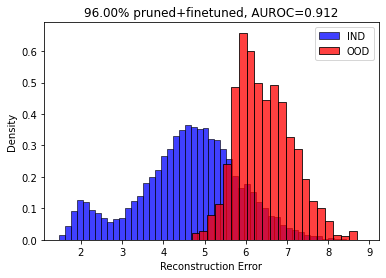

In [42]:
number = int(np.argmax(auroc_pruned_finetune))
sns.histplot(ind_recon_pruned_finetune[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned_finetune[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('{:.2f}% pruned+finetuned, AUROC={:.3f}'.format(100*xaxis_range[number],auroc_pruned_finetune[number]))

Text(0.5, 1.0, '96.00% pruned, AUROC=0.844')

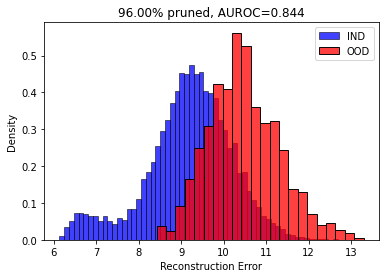

In [43]:
number = int(np.argmax(auroc_pruned_finetune))
sns.histplot(ind_recon_pruned[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('{:.2f}% pruned, AUROC={:.3f}'.format(100*xaxis_range[number],auroc_pruned[number]))

Text(0.5, 1.0, 'original network, AUROC=0.818')

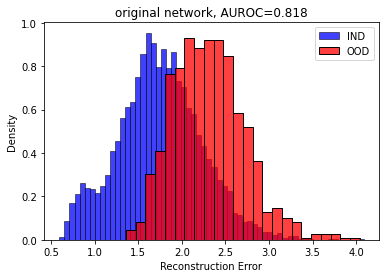

In [44]:
number = 0
sns.histplot(ind_recon_pruned[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('original network, AUROC={:.3f}'.format(auroc_pruned[number]))